In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from cmcrameri import cm
from tqdm import tqdm
import seaborn as sns
from common import *
from models import *

2021-12-17 16:03:49.255178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 16:03:49.255204: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")

price = df['NO2_price'].values.reshape(-1,1)
fload = df['NO2_load_forecasted'].values.reshape(-1,1)
aload = df['NO2_load_actual'].values.reshape(-1,1)
fgen = df['NO2_generation_forecast'].values.reshape(-1,1)
agen = df['NO2_generation_actual'].values.reshape(-1,1)


# price_days = seperate_column_to_days(price)
# aload_days = seperate_column_to_days(aload)
# fload_days = seperate_column_to_days(fload)
# fgen_days = seperate_column_to_days(fgen)
# agen_days = seperate_column_to_days(agen)

In [3]:
scaler = MinMaxScaler()
price = scaler.fit_transform(price)
fload = scaler.fit_transform(fload)
fgen = scaler.fit_transform(fgen)
agen = scaler.fit_transform(agen)
aload = scaler.fit_transform(aload)

In [4]:
lookbehind = 7
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon
# hour_in_days = int(no_hours / 24)

price_dataset = []
aload_dataset = []
fload_dataset = []
fgen_dataset = []
agen_dataset = []

"""
for i in range(len(price_days) - hour_in_days+1):
    price_dataset.append(np.concatenate((price_days[i:i+hour_in_days])))
    aload_dataset.append(np.concatenate((aload_days[i:i+hour_in_days])))
    fload_dataset.append(np.concatenate((fload_days[i:i+hour_in_days])))
    fgen_dataset.append(np.concatenate((fgen_days[i:i+hour_in_days])))
    agen_dataset.append(np.concatenate((agen_days[i:i+hour_in_days])))
"""

for i in range(0, len(price)-input_width, horizon):
    price_dataset.append(price[i:i+no_hours])
    fload_dataset.append(fload[i:i+no_hours])
    fgen_dataset.append(fgen[i:i+no_hours])
    aload_dataset.append(aload[i:i+no_hours])
    agen_dataset.append(agen[i:i+no_hours])


price_dataset = np.array(price_dataset)
aload_dataset = np.array(aload_dataset)
fload_dataset = np.array(fload_dataset)
fgen_dataset = np.array(fgen_dataset)
agen_dataset = np.array(agen_dataset)

"""
scaler = MinMaxScaler()
price_dataset = scaler.fit_transform(price_dataset[:,:,0])
price_dataset = price_dataset[..., np.newaxis].astype(np.float32)

aload_dataset = scaler.fit_transform(aload_dataset[:,:,0])
aload_dataset = aload_dataset[..., np.newaxis].astype(np.float32)

fload_dataset = scaler.fit_transform(fload_dataset[:,:,0])
fload_dataset = fload_dataset[..., np.newaxis].astype(np.float32)

fgen_dataset = scaler.fit_transform(fgen_dataset[:,:,0])
fgen_dataset = fgen_dataset[..., np.newaxis].astype(np.float32)

agen_dataset = scaler.fit_transform(agen_dataset[:,:,0])
agen_dataset = agen_dataset[..., np.newaxis].astype(np.float32)
"""

dataset_actual = np.concatenate((price_dataset, aload_dataset, agen_dataset), axis=2)
dataset_forecast = np.concatenate((price_dataset, fload_dataset, fgen_dataset), axis=2)

n,m,k = dataset_actual.shape

# Splitting the data, actual case

In [5]:
train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset_actual[:train, :input_width]
X_valid = dataset_actual[train:valid, :input_width]
X_test = dataset_actual[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset_actual[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

# Grid search, first small then large architecture

In [6]:
epochs = 10
no_neurons = np.array([16,32,64,128])
mse_list_small_actual = np.zeros((3, len(no_neurons)))
best_mse_small_actual = np.inf*np.ones(3)

In [7]:
for n, neurons in enumerate(no_neurons):
    print(f"Iteration {n}")
    rnn = keras.models.Sequential([
        keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    lstm = keras.models.Sequential([
        keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    gru = keras.models.Sequential([
        keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    rnn.compile(loss="mse", optimizer="adam")
    lstm.compile(loss="mse", optimizer="adam")
    gru.compile(loss="mse", optimizer="adam")

    rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

    Y_pred_rnn = rnn.predict(X_test)
    Y_pred_lstm = lstm.predict(X_test)
    Y_pred_gru = gru.predict(X_test)

    mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
    mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
    mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

    if mse_rnn < best_mse_small_actual[0]:
        print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons} neurons")
        best_mse_small_actual[0] = mse_rnn
        #fname = f"../data/models/multivariate_actual_small_rnn.h5"
        #keras.models.save_model(rnn, fname)

    if mse_lstm < best_mse_small_actual[1]:
        print(f"Found new best LSTM mse {mse_lstm} with {neurons} neurons")
        best_mse_small_actual[1] = mse_lstm
        #fname = f"../data/models/multivariate_actual_small_lstm.h5"
        #keras.models.save_model(lstm, fname)
        

    if mse_gru < best_mse_small_actual[2]:
        print(f"Found new best GRU mse {mse_gru} with {neurons} neurons")
        best_mse_small_actual[2] = mse_gru
        #fname = f"../data/models/multivariate_actual_small_gru.h5"
        #keras.models.save_model(gru, fname)

    mse_list_small_actual[0,n] = mse_rnn
    mse_list_small_actual[1,n] = mse_lstm
    mse_list_small_actual[2,n] = mse_gru


Iteration 0


2021-12-17 16:03:52.777711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-17 16:03:52.778241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 16:03:52.778579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-17 16:03:52.778677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-17 16:03:52.778734: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Found new best SimpleRNN mse 0.06946503324912819 with 16 neurons
Found new best LSTM mse 0.03843023101847375 with 16 neurons
Found new best GRU mse 0.05188815833834587 with 16 neurons
Iteration 1
Found new best LSTM mse 0.031938766054504124 with 32 neurons
Found new best GRU mse 0.032203090860044296 with 32 neurons
Iteration 2
Found new best SimpleRNN mse 0.03903611796082807 with 64 neurons
Found new best LSTM mse 0.028634214684348614 with 64 neurons
Found new best GRU mse 0.029008923414478933 with 64 neurons
Iteration 3


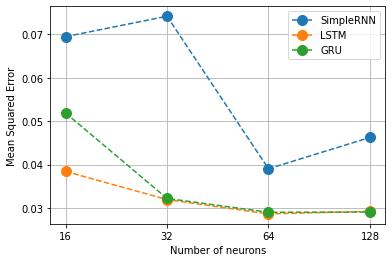

In [8]:
plt.figure()
plt.plot(mse_list_small_actual[0], '.--', markersize=20, label="SimpleRNN")
plt.plot(mse_list_small_actual[1], '.--', markersize=20, label="LSTM")
plt.plot(mse_list_small_actual[2], '.--', markersize=20, label="GRU")
plt.xticks(ticks = np.arange(4), labels=no_neurons)
plt.xlabel(f"Number of neurons")
plt.ylabel(f"Mean Squared Error")
plt.grid()
plt.legend()
plt.savefig(f"../figures/multivariate_actual_small_architecture_grid_search.pdf")

In [9]:
mse_list_actual = np.zeros((3, len(no_neurons), len(no_neurons)))
best_mse_actual = np.inf*np.ones(3)

In [10]:
for n, neurons_first in enumerate(no_neurons):
    for m, neurons_second in enumerate(no_neurons):
        print(f"Iteration {n}{m}")
        rnn = keras.models.Sequential([
            keras.layers.SimpleRNN(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.SimpleRNN(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        lstm = keras.models.Sequential([
            keras.layers.LSTM(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.LSTM(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru = keras.models.Sequential([
            keras.layers.GRU(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

        rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

        Y_pred_rnn = rnn.predict(X_test)
        Y_pred_lstm = lstm.predict(X_test)
        Y_pred_gru = gru.predict(X_test)

        mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
        mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_rnn < best_mse_actual[0]:
            print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons_first} and {neurons_second} neurons")
            best_mse_actual[0] = mse_rnn
            #fname = f"../data/models/multivariate_actual_large_rnn.h5"
            #keras.models.save_model(rnn, fname)

        if mse_lstm < best_mse_actual[1]:
            print(f"Found new best LSTM mse {mse_lstm} with {neurons_first} and {neurons_second} neurons")
            best_mse_actual[1] = mse_lstm
            #fname = f"../data/models/multivariate_actual_large_lstm.h5"
            #keras.models.save_model(lstm, fname)

        if mse_gru < best_mse_actual[2]:
            print(f"Found new best GRU mse {mse_gru} with {neurons_first} and {neurons_second} neurons")
            best_mse_actual[2] = mse_gru
            #fname = f"../data/models/multivariate_actual_large_gru.h5"
            #keras.models.save_model(gru, fname)

        mse_list_actual[0,n,m] = mse_rnn
        mse_list_actual[1,n,m] = mse_lstm
        mse_list_actual[2,n,m] = mse_gru

Iteration 00
Found new best SimpleRNN mse 0.06523608832900145 with 16 and 16 neurons
Found new best LSTM mse 0.03661029201198834 with 16 and 16 neurons
Found new best GRU mse 0.03121251839199618 with 16 and 16 neurons
Iteration 01
Found new best SimpleRNN mse 0.060152434915693304 with 16 and 32 neurons
Found new best LSTM mse 0.029728846344087696 with 16 and 32 neurons
Found new best GRU mse 0.028917218790198932 with 16 and 32 neurons
Iteration 02
Found new best SimpleRNN mse 0.035231490217611225 with 16 and 64 neurons
Found new best GRU mse 0.0285729061309616 with 16 and 64 neurons
Iteration 03
Found new best LSTM mse 0.028824507079350737 with 16 and 128 neurons
Iteration 10
Iteration 11
Found new best GRU mse 0.0285451590690171 with 32 and 32 neurons
Iteration 12
Iteration 13
Iteration 20
Iteration 21
Found new best GRU mse 0.02799481167896391 with 64 and 32 neurons
Iteration 22
Found new best LSTM mse 0.028758296531638517 with 64 and 64 neurons
Iteration 23
Found new best LSTM mse 0

In [11]:
print(mse_list_actual)
print(best_mse_actual)

[[[0.06523609 0.06015243 0.03523149 0.04645706]
  [0.0622795  0.07444713 0.04221747 0.04524665]
  [0.05904648 0.08384913 0.04244334 0.04215672]
  [0.06331027 0.0454466  0.04097082 0.04587004]]

 [[0.03661029 0.02972885 0.02984826 0.02882451]
  [0.04179968 0.03140199 0.02973252 0.02926805]
  [0.03899486 0.03129704 0.0287583  0.02866078]
  [0.0384811  0.02956351 0.02987704 0.02941501]]

 [[0.03121252 0.02891722 0.02857291 0.0292604 ]
  [0.03062062 0.02854516 0.02919479 0.03105481]
  [0.03440136 0.02799481 0.03052687 0.02969047]
  [0.03147153 0.02833354 0.02901785 0.02996396]]]
[0.03523149 0.02866078 0.02799481]


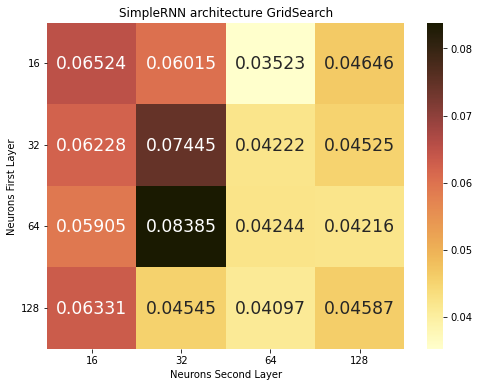

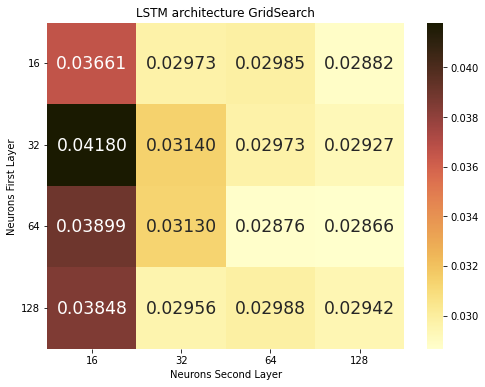

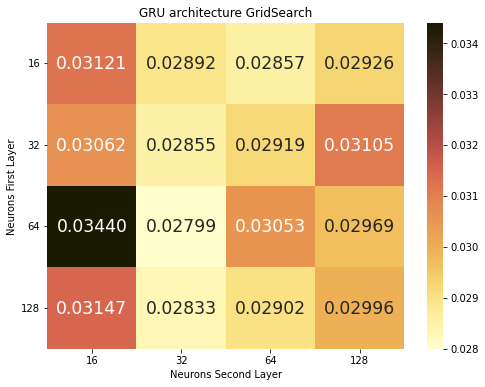

In [12]:
plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_actual[0],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("SimpleRNN architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_actual_gridsearch_rnn.pdf")

plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_actual[1],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("LSTM architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_actual_gridsearch_lstm.pdf")

plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_actual[2],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("GRU architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_actual_gridsearch_gru.pdf")

# Splitting the data, forecast case

In [11]:
n,m,k = dataset_forecast.shape

train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset_forecast[:train, :input_width]
X_valid = dataset_forecast[train:valid, :input_width]
X_test = dataset_forecast[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset_forecast[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

In [12]:
epochs = 10
no_neurons = np.array([16,32,64,128])
mse_list_small_forecast = np.zeros((3, len(no_neurons)))
best_mse_small_forecast = np.inf*np.ones(3)

In [13]:
for n, neurons in enumerate(no_neurons):
    print(f"Iteration {n}")
    rnn = keras.models.Sequential([
        keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    lstm = keras.models.Sequential([
        keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    gru = keras.models.Sequential([
        keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

    rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

    Y_pred_rnn = rnn.predict(X_test)
    Y_pred_lstm = lstm.predict(X_test)
    Y_pred_gru = gru.predict(X_test)

    mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
    mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
    mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

    if mse_rnn < best_mse_small_forecast[0]:
        print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons} neurons")
        best_mse_small_forecast[0] = mse_rnn
        #fname = f"../data/models/multivariate_forecast_small_rnn.h5"
        #keras.models.save_model(rnn, fname)

    if mse_lstm < best_mse_small_forecast[1]:
        print(f"Found new best LSTM mse {mse_lstm} with {neurons} neurons")
        best_mse_small_forecast[1] = mse_lstm
        #fname = f"../data/models/multivariate_forecast_small_lstm.h5"
        #keras.models.save_model(lstm, fname)
        

    if mse_gru < best_mse_small_forecast[2]:
        print(f"Found new best GRU mse {mse_gru} with {neurons} neurons")
        best_mse_small_forecast[2] = mse_gru
        #fname = f"../data/models/multivariate_forecast_small_gru.h5"
        #keras.models.save_model(gru, fname)

    mse_list_small_forecast[0,n] = mse_rnn
    mse_list_small_forecast[1,n] = mse_lstm
    mse_list_small_forecast[2,n] = mse_gru


Iteration 0
Found new best SimpleRNN mse 0.0725324624828254 with 16 neurons
Found new best LSTM mse 0.03892436174275779 with 16 neurons
Found new best GRU mse 0.0894964078102356 with 16 neurons
Iteration 1
Found new best SimpleRNN mse 0.048790748139594796 with 32 neurons
Found new best LSTM mse 0.029042172282550932 with 32 neurons
Found new best GRU mse 0.031710000539291995 with 32 neurons
Iteration 2
Found new best SimpleRNN mse 0.040344588081305595 with 64 neurons
Found new best LSTM mse 0.02831342721824623 with 64 neurons
Found new best GRU mse 0.029876319243667692 with 64 neurons
Iteration 3
Found new best SimpleRNN mse 0.03455112543673173 with 128 neurons
Found new best GRU mse 0.028876299169257925 with 128 neurons


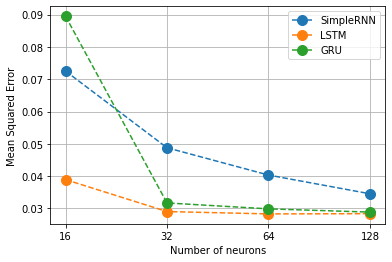

In [20]:
plt.figure()
plt.plot(mse_list_small_forecast[0], '.--', markersize=20, label="SimpleRNN")
plt.plot(mse_list_small_forecast[1], '.--', markersize=20, label="LSTM")
plt.plot(mse_list_small_forecast[2], '.--', markersize=20, label="GRU")
plt.xticks(ticks = np.arange(4), labels=no_neurons)
plt.xlabel(f"Number of neurons")
plt.ylabel(f"Mean Squared Error")
plt.grid()
plt.legend()
plt.savefig(f"../figures/multivariate_forecast_small_architecture_grid_search.pdf")

In [15]:
mse_list_forecast = np.zeros((3, len(no_neurons), len(no_neurons)))
best_mse_forecast = np.inf*np.ones(3)

In [16]:
for n, neurons_first in enumerate(no_neurons):
    for m, neurons_second in enumerate(no_neurons):
        print(f"Iteration {n}{m}")
        rnn = keras.models.Sequential([
            keras.layers.SimpleRNN(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.SimpleRNN(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        lstm = keras.models.Sequential([
            keras.layers.LSTM(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.LSTM(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru = keras.models.Sequential([
            keras.layers.GRU(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

        rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

        Y_pred_rnn = rnn.predict(X_test)
        Y_pred_lstm = lstm.predict(X_test)
        Y_pred_gru = gru.predict(X_test)

        mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
        mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_rnn < best_mse_forecast[0]:
            print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons_first} and {neurons_second} neurons")
            best_mse_forecast[0] = mse_rnn
            #fname = f"../data/models/multivariate_forecast_large_rnn.h5"
            #keras.models.save_model(rnn, fname)

        if mse_lstm < best_mse_forecast[1]:
            print(f"Found new best LSTM mse {mse_lstm} with {neurons_first} and {neurons_second} neurons")
            best_mse_forecast[1] = mse_lstm
            #fname = f"../data/models/multivariate_forecast_large_lstm.h5"
            #keras.models.save_model(lstm, fname)

        if mse_gru < best_mse_forecast[2]:
            print(f"Found new best GRU mse {mse_gru} with {neurons_first} and {neurons_second} neurons")
            best_mse_forecast[2] = mse_gru
            #fname = f"../data/models/multivariate_forecast_large_gru.h5"
            #keras.models.save_model(gru, fname)

        mse_list_forecast[0,n,m] = mse_rnn
        mse_list_forecast[1,n,m] = mse_lstm
        mse_list_forecast[2,n,m] = mse_gru

Iteration 00
Found new best SimpleRNN mse 0.10222181670429635 with 16 and 16 neurons
Found new best LSTM mse 0.03476086161504846 with 16 and 16 neurons
Found new best GRU mse 0.03453817479420739 with 16 and 16 neurons
Iteration 01
Found new best SimpleRNN mse 0.0633923833905181 with 16 and 32 neurons
Found new best LSTM mse 0.030756863722270027 with 16 and 32 neurons
Found new best GRU mse 0.029777074366383483 with 16 and 32 neurons
Iteration 02
Found new best SimpleRNN mse 0.04452356269520589 with 16 and 64 neurons
Found new best LSTM mse 0.029660604993694144 with 16 and 64 neurons
Found new best GRU mse 0.02865700112899691 with 16 and 64 neurons
Iteration 03
Found new best SimpleRNN mse 0.04451835833126338 with 16 and 128 neurons
Iteration 10
Iteration 11
Iteration 12
Found new best SimpleRNN mse 0.039738570672167045 with 32 and 64 neurons
Iteration 13
Found new best GRU mse 0.02860885278721619 with 32 and 128 neurons
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Found new best

In [17]:
print(mse_list_forecast)
print(best_mse_forecast)

[[[0.10222182 0.06339238 0.04452356 0.04451836]
  [0.0645434  0.04967926 0.03973857 0.04987432]
  [0.10111946 0.09214305 0.04066579 0.04629343]
  [0.05627309 0.06447712 0.0524842  0.05401002]]

 [[0.03476086 0.03075686 0.0296606  0.03248462]
  [0.04135794 0.03071607 0.02980243 0.03033723]
  [0.0408822  0.03097277 0.02966662 0.02873595]
  [0.03705482 0.03035231 0.03097731 0.03031068]]

 [[0.03453817 0.02977707 0.028657   0.02945591]
  [0.03145132 0.02994717 0.02882961 0.02860885]
  [0.03034403 0.02861357 0.02902007 0.02829481]
  [0.03280621 0.02855471 0.0302407  0.02900399]]]
[0.03973857 0.02873595 0.02829481]


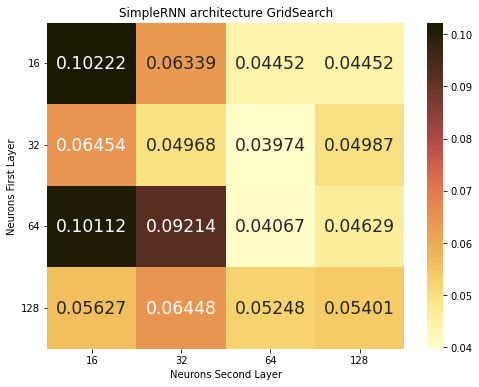

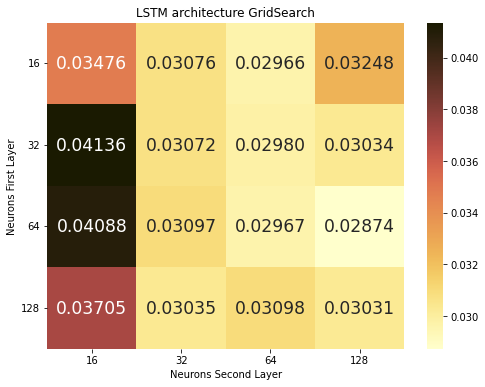

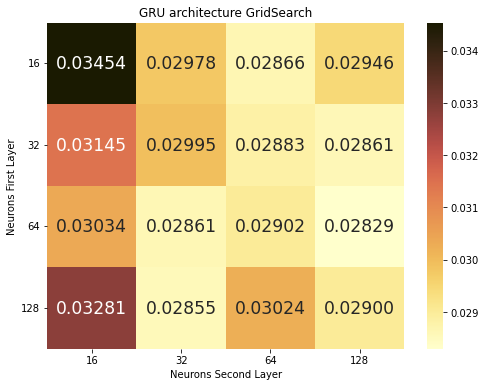

In [19]:
fig = plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_forecast[0],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("SimpleRNN architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_forecast_gridsearch_rnn.pdf")

fig = plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_forecast[1],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("LSTM architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_forecast_gridsearch_lstm.pdf")

fig = plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_forecast[2],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("GRU architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_forecast_gridsearch_gru.pdf")